In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.
C:\Users\acall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\acall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [ ]:
data = pd.read_csv('DTDec_April_Directed.csv', engine = 'python', error_bad_lines = False)

In [ ]:
data = data[['text','Rating']]

In [ ]:
data.head()

,text,Rating
0,I thought you hired the best people?,Negative
1,Did Rudy tell you this? You do know heâ€™s mor...,Negative
2,1. She's Blond 2. She used to work for fox new...,Negative
3,Fat Chance!,D
4,@realDonaldTrump might as well meet with the S...,Negative


In [ ]:
data.tail()

,text,Rating
3816,Wow.,D
3817,Exactly !!,D
3818,ThOuGhTs AnD PrAyErS,D
3819,If you and the disgusting @NRA didn't arm ever...,Negative
3820,Should we ignore donald j trumpâ€™s past....oh...,Negative


In [ ]:
data = data.dropna(subset=['Rating', 'text'])

In [ ]:
data = data[data['Rating'] != 'D']

In [ ]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['Rating'] == 'Positive'].size)
print(data[ data['Rating'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

1310
4420


In [ ]:
data['text'].values

array(['i thought you hired the best people',
       'did rudy tell you this you do know hes more demented than you',
       '1 shes blond 2 she used to work for fox news 3 she used to work for fox news 3 she used to work for fox news there shes impeccably qualified for playing trumps stooge on the world stage sorry nikki you did a credible job',
       ...,
       'as opposed to the white supremacist who posed as law enforcement a crime kidnapped asylum seekers a crime and is now along with his criminal coho s in police custody thank god im an american and notmypresident',
       'if you and the disgusting nra didnt arm every hater in america without a proper background check this wouldnt happen it doesnt happen in other developed countries cant wait to vote you out realdonaldtrump',
       'should we ignore donald j trumps pastoh wait those who enthusiastically voted for himminus the many who held their noses while doing soeither didnt care or were ce ain he had changedat the young a

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 71, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Y = pd.get_dummies(data['Rating']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1919, 71) (1919, 2)
(946, 71) (946, 2)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)


Epoch 1/7
 - 4s - loss: 0.5612 - accuracy: 0.7603
Epoch 2/7
 - 4s - loss: 0.4793 - accuracy: 0.7718
Epoch 3/7
 - 4s - loss: 0.3534 - accuracy: 0.8437
Epoch 4/7
 - 4s - loss: 0.2679 - accuracy: 0.8979
Epoch 5/7
 - 3s - loss: 0.2033 - accuracy: 0.9234
Epoch 6/7
 - 3s - loss: 0.1472 - accuracy: 0.9468
Epoch 7/7
 - 3s - loss: 0.1073 - accuracy: 0.9620


In [ ]:
validation_size = 150

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.80
acc: 0.77


In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 43.333333333333336 %
neg_acc 87.5 %


## Equal training

In [ ]:
dataP = data[ data['Rating'] == 'Positive']
dataN = data[ data['Rating'] == 'Negative']
dataO = pd.concat([dataP, dataN])

In [ ]:
dataO['text'] = dataO['text'].apply(lambda x: x.lower())
dataO['text'] = dataO['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(dataO[ dataO['Rating'] == 'Positive'].size)
print(dataO[ dataO['Rating'] == 'Negative'].size)

for idx,row in dataO.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataO['text'].values)
Xo = tokenizer.texts_to_sequences(dataO['text'].values)
Xo = pad_sequences(Xo)
print(Xo.shape)

1310
4420
(2865, 71)


In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def lemma_stop_preprocess(df):
    nltkTok = []
    lemmatizer = WordNetLemmatizer()

    for x in df['text']:
        nltkTok.append(word_tokenize(x))

    for x in range(len(nltkTok)):
        nltkTok[x] = [w for w in nltkTok[x] if not w in stop_words]
        for y in range(len(nltkTok[x])):
            nltkTok[x][y] = lemmatizer.lemmatize(nltkTok[x][y])

    retList = []
    for lis in nltkTok:
        retList.append(' '.join(lis))

    rDF = pd.DataFrame(retList, columns=['text'])
    return rDF

In [ ]:
newData = lemma_stop_preprocess(dataO)

tokenizer.fit_on_texts(newData['text'].values)
Xo = tokenizer.texts_to_sequences(newData['text'].values)
Xo = pad_sequences(Xo)
print(Xo.shape)

(2865, 67)


In [ ]:
Xp = Xo[:655, :]
Xn = Xo[655:, :]

Yo = pd.get_dummies(dataO['Rating']).values
Yp = Yo[:655, :]
Yn = Yo[655:, :]

In [ ]:
#Yp = pd.get_dummies(dataP['Rating']).values
Xp_train, Xp_test, Yp_train, Yp_test = train_test_split(Xp,Yp, test_size = 0.19, random_state = 42)
print(Xp_train.shape,Yp_train.shape)
print(Xp_test.shape,Yp_test.shape)

(530, 67) (530, 2)
(125, 67) (125, 2)


In [ ]:
#Yn = pd.get_dummies(dataN['Rating']).values
Xn_train, Xn_test, Yn_train, Yn_test = train_test_split(Xn,Yn, test_size = 0.75, random_state = 42)
print(Xn_train.shape,Yn_train.shape)
print(Xn_test.shape,Yn_test.shape)

(552, 67) (552, 2)
(1658, 67) (1658, 2)


In [ ]:
type(Xn_train)

numpy.ndarray

In [ ]:
Xo_train = np.concatenate((Xp_train, Xn_train))
Xo_test = np.concatenate((Xp_test, Xn_test))
Yo_train = np.concatenate((Yp_train, Yn_train))
Yo_test = np.concatenate((Yp_test, Yn_test))

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = Xo.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 67, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 67, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32
model.fit(Xo_train, Yo_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
 - 2s - loss: 0.6872 - accuracy: 0.5684
Epoch 2/7
 - 2s - loss: 0.6220 - accuracy: 0.6913
Epoch 3/7
 - 2s - loss: 0.4614 - accuracy: 0.8207
Epoch 4/7
 - 2s - loss: 0.3124 - accuracy: 0.8762
Epoch 5/7
 - 2s - loss: 0.2197 - accuracy: 0.9150
Epoch 6/7
 - 2s - loss: 0.1841 - accuracy: 0.9399
Epoch 7/7
 - 2s - loss: 0.1298 - accuracy: 0.9510


In [ ]:
score,acc = model.evaluate(Xo_test, Yo_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.04
acc: 0.67


In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(Xo_test)):

    result = model.predict(Xo_test[x].reshape(1,Xo_test.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Yo_test[x]):
        if np.argmax(Yo_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Yo_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 68.0 %
neg_acc 67.43063932448733 %


## Using the Equal Model on Feb to March data

In [ ]:
fmDat0 = pd.read_csv('Feb_to_March2020.csv', engine = 'python', error_bad_lines = False)

In [ ]:
fmDat0 = fmDat0.dropna(subset=['Unnamed: 1', 'Unnamed: 2'])

In [ ]:
fmDat0.rename(columns = {'Unnamed: 1':'text'}, inplace = True)

In [ ]:
fmDat = lemma_stop_preprocess(fmDat0)
fmDat.rename(columns = {'text':'Unnamed: 1'}, inplace = True)
fmDat = fmDat["Unnamed: 1"]

In [ ]:
a = tokenizer.texts_to_sequences(fmDat)
a = pad_sequences(a, maxlen= 67)

In [ ]:
res = model.predict(a,batch_size=1,verbose = 2)

In [ ]:
res

array([[9.9869955e-01, 1.3004501e-03],
       [7.8111982e-01, 2.1888021e-01],
       [9.9907827e-01, 9.2175108e-04],
       ...,
       [8.8983405e-01, 1.1016597e-01],
       [9.3175542e-01, 6.8244554e-02],
       [1.6850410e-02, 9.8314959e-01]], dtype=float32)

In [ ]:
def day_Res(data, res):
    preds = []
    for x in res:
        if np.argmax(x) == 0:
            preds.append('Negative')
        else:
            preds.append('Positive')

    dates = []
    for x in data["Unnamed: 2"]:
        #print(x)
        dates.append(x[:10])

    data["Unnamed: 2"] = dates

    mergedf = pd.concat([data.reset_index(drop=True), pd.DataFrame(preds, columns=['a'])], axis = 1)

    predMat = []
    monthCheck = []
    for x in mergedf['Unnamed: 2'].value_counts().index.sort_values():
        monthCheck.append(x[6])
        if monthCheck[0] != x[6]:
            break
        if mergedf[mergedf['Unnamed: 2'] == x]['a'].value_counts().index[0] == 'Negative':
            neg = mergedf[mergedf['Unnamed: 2'] == x]['a'].value_counts()[0]
            pos = mergedf[mergedf['Unnamed: 2'] == x]['a'].value_counts()[1]
        elif mergedf[mergedf['Unnamed: 2'] == x]['a'].value_counts().index[0] == 'Positive':
            neg = mergedf[mergedf['Unnamed: 2'] == x]['a'].value_counts()[0]
            pos = mergedf[mergedf['Unnamed: 2'] == x]['a'].value_counts()[1]
        else:
            print("error")

        predMat.append([x, neg, pos])

    return predMat

In [ ]:
feb = np.array(day_Res(fmDat0, res))

In [ ]:
fmDat0

,Unnamed: 0,text,Unnamed: 2,Unnamed: 3
0,1.223758e+18,It would have been tied up in the courts for 2...,2020-02-01,https://twitter.com/rsmack123/status/122375792...
1,1.223758e+18,Get da they had 18 witnesses in the house,2020-02-01,https://twitter.com/shortly2600/status/1223757...
2,1.223758e+18,"@realDonaldTrump , President Trump please Tell...",2020-02-01,https://twitter.com/FloydCapone3rd/status/1223...
3,1.223758e+18,#Barrage sur le #Nil : @realDonaldTrump Â« opt...,2020-02-01,https://twitter.com/le_4eme_pouvoir/status/122...
4,1.223758e+18,,2020-02-01,https://twitter.com/LadyDi92115237/status/1223...
...,...,...,...,...
28995,1.233904e+18,Must be a relative. 98 percent thinks the todd...,2020-02-29,https://twitter.com/AflagueMona/status/1233903...
28996,1.233904e+18,Love this!,2020-02-29,https://twitter.com/irenenoe52/status/12339038...
28997,1.233904e+18,Sad they just walk out...can't Hear the truth....,2020-02-29,https://twitter.com/Johooklo/status/1233903809...
28998,1.233904e+18,I want coronavirus!!! I WANT TO BE BED RIDDEN,2020-02-29,https://twitter.com/Chip_Crocker/status/123390...


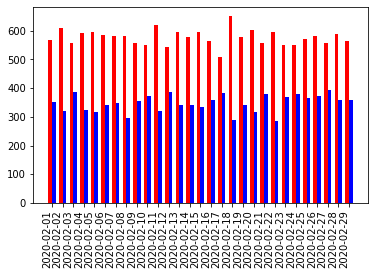

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(feb)) - 0.35/2, feb[:, 1].astype('int'), color = 'r', width = 0.35)
ax.bar(np.arange(len(feb)) + 0.35/2, feb[:, 2].astype('int'), color = 'b', width = 0.35)
ax.set_xticks(np.arange(len(feb)))
ax.set_xticklabels(feb[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

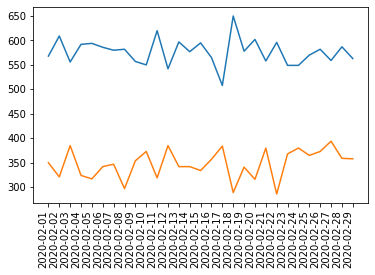

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(feb)), feb[:, 1].astype('int'), feb[:, 2].astype('int'))
ax.set_xticks(np.arange(len(feb)))
ax.set_xticklabels(feb[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

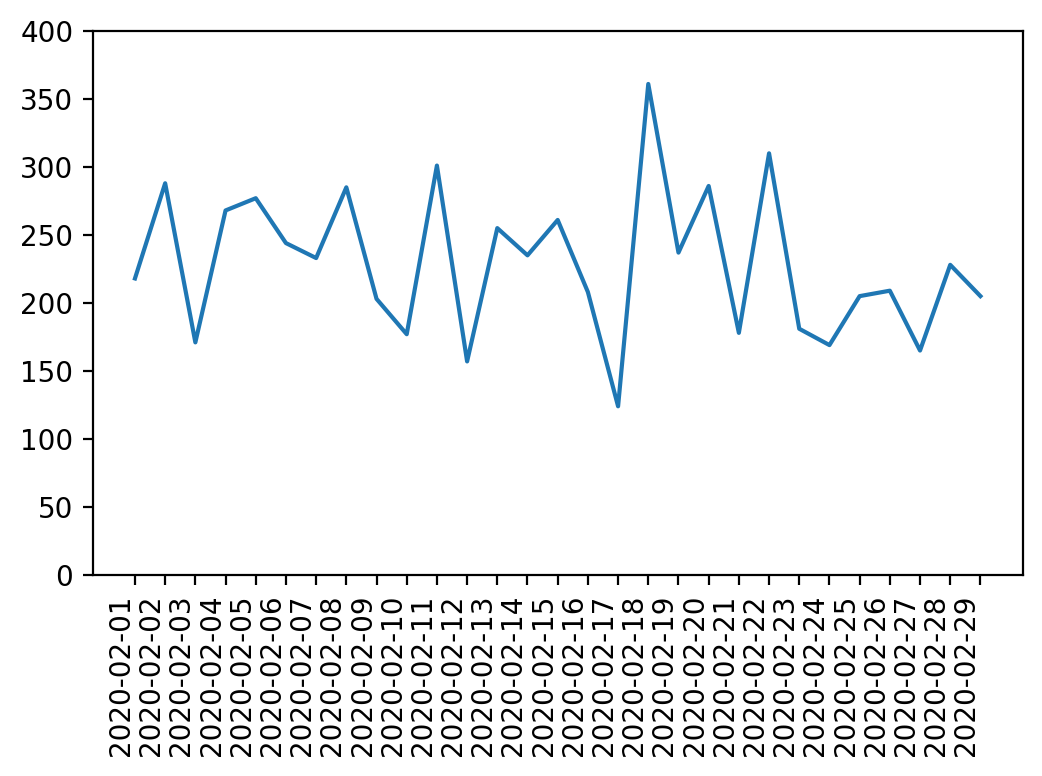

In [ ]:
diff = feb[:, 1].astype('int') - feb[:, 2].astype('int')

fig, ax = plt.subplots(dpi=200)

ax.plot(range(len(feb)), diff)
ax.set_ylim([0,400])
ax.set_xticks(np.arange(len(feb)))
ax.set_xticklabels(feb[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

## Using the Equal Model on March to April data

In [ ]:
fmDat0 = pd.read_excel('Mar_to_Apr2020.xlsx', error_bad_lines = False)
fmDat0 = fmDat0.dropna(subset=['Unnamed: 1', 'Unnamed: 2'])

In [ ]:
fmDat0

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,1234227767526481923,Don't forget wilkes barr,2020-03-01 21:23:25,https://twitter.com/Againstthewind3/status/123...
1,1234227927929147393,,2020-03-01 21:24:03,https://twitter.com/lmkolb1212/status/12342279...
2,1234227949492039681,And 3. 2. 1. ....full meltdown in progress fro...,2020-03-01 21:24:08,https://twitter.com/WGlass62/status/1234227949...
3,1234227967783555072,Good job Joeblow4510132 you earned 1 rubble fo...,2020-03-01 21:24:13,https://twitter.com/elikensun/status/123422796...
4,1234227981893005312,My guess is you don't like a free press. Or an...,2020-03-01 21:24:16,https://twitter.com/BlaiddAp/status/1234227981...
...,...,...,...,...
30921,1304010760067059712,"With 12 outlets, dual surge protection, and ov...",2020-09-10 10:56:07,https://twitter.com/AnkerOfficial/status/13040...
30922,1304010760067059712,"With 12 outlets, dual surge protection, and ov...",2020-09-10 10:56:07,https://twitter.com/AnkerOfficial/status/13040...
30923,1304010760067059712,"With 12 outlets, dual surge protection, and ov...",2020-09-10 10:56:07,https://twitter.com/AnkerOfficial/status/13040...
30924,1304010760067059712,"With 12 outlets, dual surge protection, and ov...",2020-09-10 10:56:07,https://twitter.com/AnkerOfficial/status/13040...


In [ ]:
fmDat0.rename(columns = {'Unnamed: 1':'text'}, inplace = True)
fmDat = lemma_stop_preprocess(fmDat0)
fmDat.rename(columns = {'text':'Unnamed: 1'}, inplace = True)
fmDat = fmDat["Unnamed: 1"]

In [ ]:
fmDat0['Unnamed: 2'] = fmDat0['Unnamed: 2'].astype(str)
fmDat0 = fmDat0.reset_index(drop=True)

In [ ]:
for x in range(len(fmDat0['Unnamed: 2'])):
    fmDat0['Unnamed: 2'][x] = fmDat0['Unnamed: 2'][x][:10]

C:\Users\acall\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
fmDat0['Unnamed: 2']

0        2020-03-01
1        2020-03-01
2        2020-03-01
3        2020-03-01
4        2020-03-01
            ...    
29607    2020-09-10
29608    2020-09-10
29609    2020-09-10
29610    2020-09-10
29611    2020-09-11
Name: Unnamed: 2, Length: 29612, dtype: object

In [ ]:
a = tokenizer.texts_to_sequences(fmDat)
a = pad_sequences(a, maxlen= 67)

In [ ]:
res = model.predict(a,batch_size=1,verbose = 2)

In [ ]:
mar = np.array(day_Res(fmDat0, res))

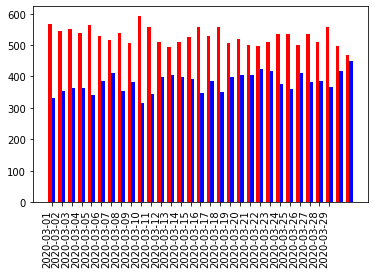

In [ ]:
fig, ax = plt.subplots()
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(mar)) - 0.35/2, mar[:, 1].astype('int'), color = 'r', width = 0.35)
ax.bar(np.arange(len(mar)) + 0.35/2, mar[:, 2].astype('int'), color = 'b', width = 0.35)
ax.set_xticks(np.arange(len(feb)))
ax.set_xticklabels(mar[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

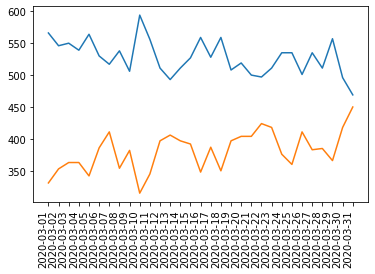

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(mar)), mar[:, 1].astype('int'), mar[:, 2].astype('int'))
ax.set_xticks(np.arange(len(mar)))
ax.set_xticklabels(mar[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

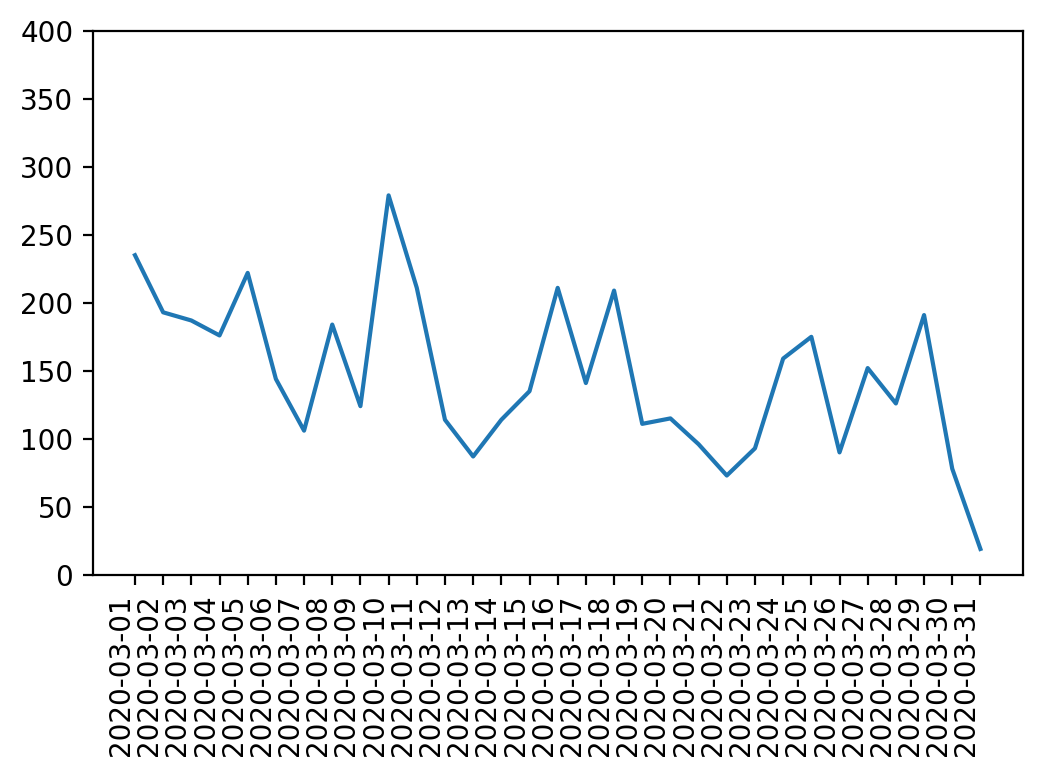

In [ ]:
diff = mar[:, 1].astype('int') - mar[:, 2].astype('int')

fig, ax = plt.subplots(dpi=200)

ax.plot(range(len(mar)), diff)
ax.set_ylim([0,400])
ax.set_xticks(np.arange(len(mar)))
ax.set_xticklabels(mar[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

## Using the Equal Model on April to May data

In [ ]:
fmDat0 = pd.read_csv('Apr_to_May2020.csv', engine = 'python', header=None, error_bad_lines = False)
fmDat0.rename(columns = {1:'Unnamed: 1', 2:'Unnamed: 2'}, inplace = True)
fmDat0 = fmDat0.dropna(subset=['Unnamed: 1', 'Unnamed: 2'])

In [ ]:
fmDat0.rename(columns = {'Unnamed: 1':'text'}, inplace = True)
fmDat = lemma_stop_preprocess(fmDat0)
fmDat.rename(columns = {'text':'Unnamed: 1'}, inplace = True)
fmDat = fmDat["Unnamed: 1"]

In [ ]:
a = tokenizer.texts_to_sequences(fmDat)
a = pad_sequences(a, maxlen= 67)

In [ ]:
res = model.predict(a,batch_size=1,verbose = 2)

In [ ]:
apr = np.array(day_Res(fmDat0, res))

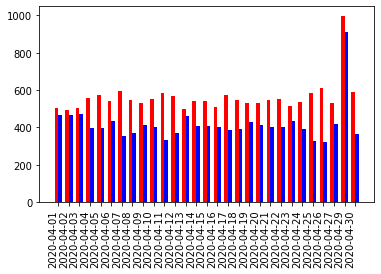

In [ ]:
fig, ax = plt.subplots()
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(apr)) - 0.35/2, apr[:, 1].astype('int'), color = 'r', width = 0.35)
ax.bar(np.arange(len(apr)) + 0.35/2, apr[:, 2].astype('int'), color = 'b', width = 0.35)
ax.set_xticks(np.arange(len(apr)))
ax.set_xticklabels(apr[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

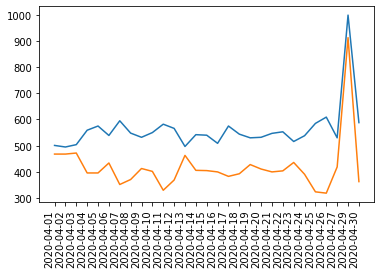

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(apr)), apr[:, 1].astype('int'), apr[:, 2].astype('int'))
ax.set_xticks(np.arange(len(apr)))
ax.set_xticklabels(apr[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

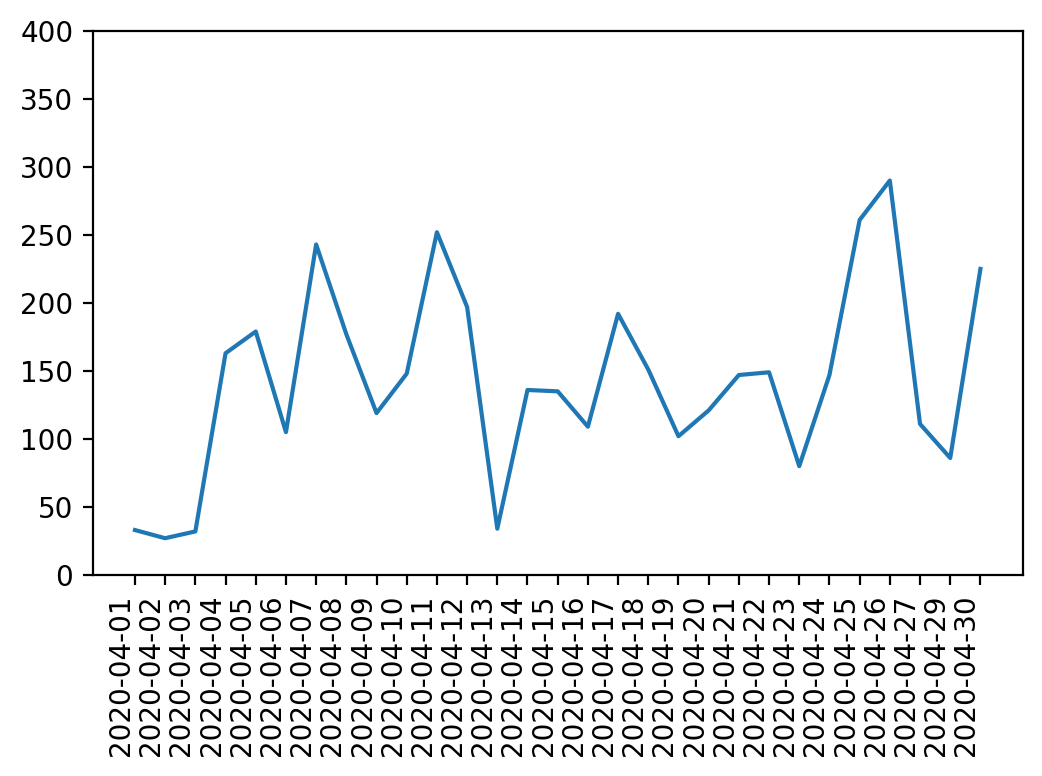

In [ ]:
diff = apr[:, 1].astype('int') - apr[:, 2].astype('int')

fig, ax = plt.subplots(dpi=200)

ax.plot(range(len(apr)), diff)
ax.set_ylim([0,400])
ax.set_xticks(np.arange(len(apr)))
ax.set_xticklabels(apr[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

## Using the Equal Model on May to June data

In [ ]:
fmDat0 = pd.read_csv('May_to_Jun2020.csv', engine = 'python', header=None, error_bad_lines = False)
fmDat0.rename(columns = {1:'Unnamed: 1', 2:'Unnamed: 2'}, inplace = True)
fmDat0 = fmDat0.dropna(subset=['Unnamed: 1', 'Unnamed: 2'])

In [ ]:
fmDat0.rename(columns = {'Unnamed: 1':'text'}, inplace = True)
fmDat = lemma_stop_preprocess(fmDat0)
fmDat.rename(columns = {'text':'Unnamed: 1'}, inplace = True)
fmDat = fmDat["Unnamed: 1"]

In [ ]:
a = tokenizer.texts_to_sequences(fmDat)
a = pad_sequences(a, maxlen= 67)

In [ ]:
res = model.predict(a,batch_size=1,verbose = 2)

In [ ]:
may = np.array(day_Res(fmDat0, res))

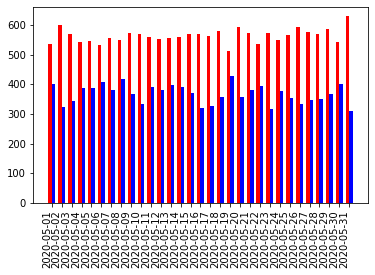

In [ ]:
fig, ax = plt.subplots()
#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(may)) - 0.35/2, may[:, 1].astype('int'), color = 'r', width = 0.35)
ax.bar(np.arange(len(may)) + 0.35/2, may[:, 2].astype('int'), color = 'b', width = 0.35)
ax.set_xticks(np.arange(len(may)))
ax.set_xticklabels(may[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

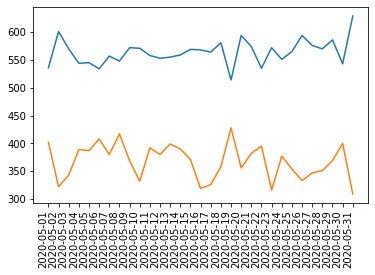

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(may)), may[:, 1].astype('int'), may[:, 2].astype('int'))
ax.set_xticks(np.arange(len(may)))
ax.set_xticklabels(may[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

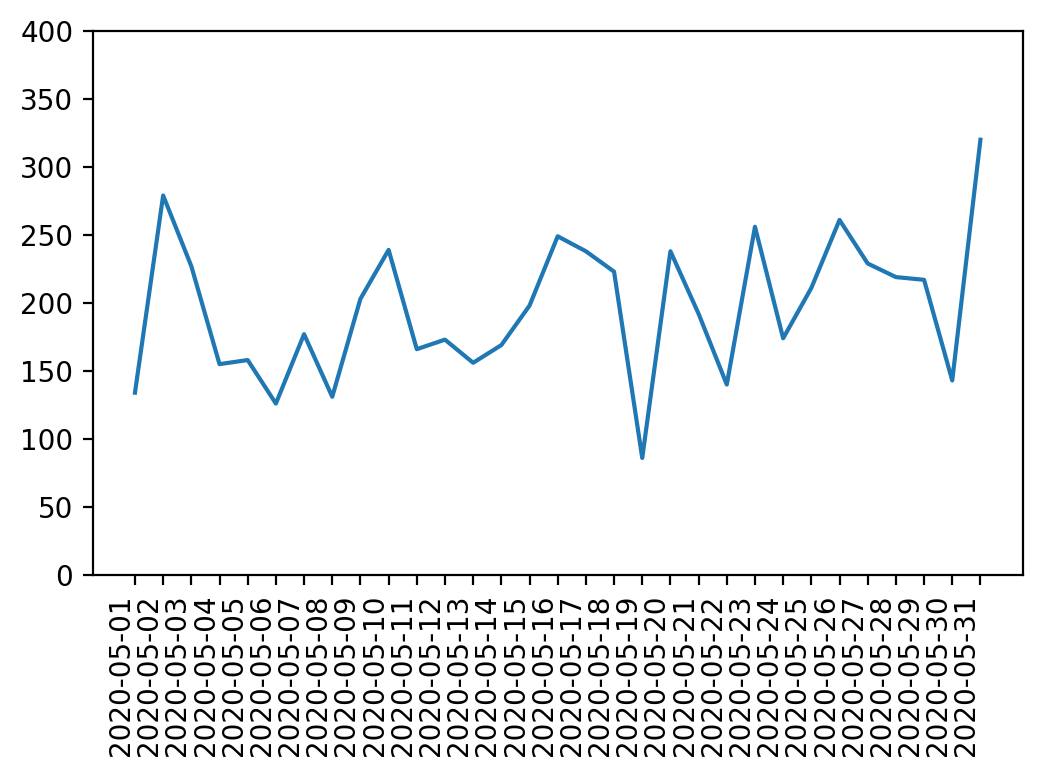

In [ ]:
diff = may[:, 1].astype('int') - may[:, 2].astype('int')

fig, ax = plt.subplots(dpi=200)

ax.plot(range(len(may)), diff)
ax.set_ylim([0,400])
ax.set_xticks(np.arange(len(may)))
ax.set_xticklabels(may[:,0])
fig.autofmt_xdate(rotation=90)
plt.show()

In [ ]:
febDF = pd.DataFrame(feb, columns = ["date", "negative_tweets", "positive_tweets"])
febDF.to_csv('lstmPred_feb2020.csv', index=False)

In [ ]:
marDF = pd.DataFrame(mar, columns = ["date", "negative_tweets", "positive_tweets"])
marDF.to_csv('lstmPred_mar2020.csv', index=False)

In [ ]:
aprDF = pd.DataFrame(apr, columns = ["date", "negative_tweets", "positive_tweets"])
aprDF.to_csv('lstmPred_apr2020.csv', index=False)

In [ ]:
mayDF = pd.DataFrame(may, columns = ["date", "negative_tweets", "positive_tweets"])
mayDF.to_csv('lstmPred_may2020.csv', index=False)